<IPython.core.display.Javascript object>


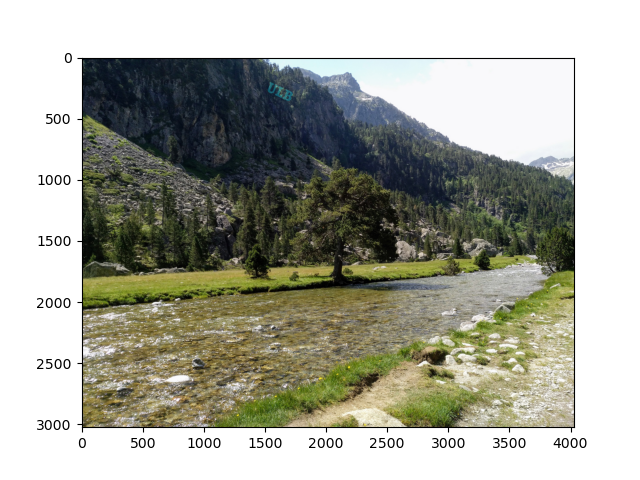

In [4]:
from skimage.io import imread,imsave,imshow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
%matplotlib notebook


def setPos(pos, im_shape, wm_shape):        #Set the position of the watermark
    topleft_y = im_shape[0]//2 - wm_shape[0]//2
    topleft_x = im_shape[1]//2 - wm_shape[1]//2
    if(type(pos)== tuple):                  #If the position given is coordinates, use them
        topleft_y = pos[0]
        topleft_x = pos[1]
    elif(type(pos)== str):                  #Else, create a relative position in the photo
        if(pos in ('TL','ML','BL')):
            topleft_x = 10
        elif(pos in ('TR','MR','BR')):
            topleft_x = im_shape[1] - wm_shape[1] - 10
        
        if(pos in ('TL', 'TM', 'TR')):
            topleft_y = 10
        elif(pos in ('BL', 'BM', 'BR')):
            topleft_y = im_shape[0] - wm_shape[0] - 10
    return topleft_y,topleft_x

def wm2bin(wm):
    for i in range(wm.shape[0]):
        for j in range(wm.shape[1]):
            if(wm[i,j]<(wm.max()/2)):      #If pixel value under 128, it's black, else it's white
                wm[i,j] = 0
            else:
                wm[i,j] = 1
    return wm

def getLocalLuminosity(im):
    total_value = im.sum() #Sum of all pixel values
    number_values = 1
    for i in range(len(im.shape)):
        number_values *= im.shape[i] #Number of value in the sub_image
    
    return total_value/number_values

def applyWatermark(im, wm, intensity, color): 
    intensity += 20
    luminosity = getLocalLuminosity(im)   #Measure the luminosity of the watermarked region
    if(luminosity > (1.4*intensity)):     #If the region is light, the watermark will be dark, else light
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                for k in range(im.shape[2]):
                    if(wm[i,j]!=0):       #Ignore black pixels
                        if((im[i,j,k]-intensity)>0):
                            im[i,j,k] -= intensity*wm[i,j]*((256-color[k])/256)  #Reduce intesity in each color depending on the color
                        else:
                            im[i,j,k] = 0
    else:
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                for k in range(im.shape[2]):
                    if(wm[i,j]!=0):
                        if((im[i,j,k]+intensity)<255):
                            im[i,j,k] += intensity*wm[i,j]*((256-color[k])/256)
                        else:
                            im[i,j,k] = 255
    
    return im

def watermark(image = 'road.jpg', watermark = 'watermark.png', pos=('M'), intensity = 30, color = (0,0,0), rotation = 0):
    im = imread(image)
    wm = Image.open(watermark)                   #Import image with PIL
    wm = wm.rotate(rotation, Image.NEAREST, 1)   #Rotate image with PIL
    wm = np.asarray(wm).copy()                   #Transform image to an np array
    wm_y = wm.shape[0]
    wm_x = wm.shape[1]
    wm = wm2bin(wm) #Rendre l'image binaire avec un seuil à 128
    
    topleft_y,topleft_x = setPos(pos, im.shape, wm.shape) #Définir la position de l'image
    
    part_im = im[topleft_y:topleft_y+wm_y,topleft_x:topleft_x+wm_x] #Crop the part of the image where the watermark will go
    
    part_im = applyWatermark(part_im, wm, intensity, color) #Apply watermark
    
    im[topleft_y:topleft_y+wm_y,topleft_x:topleft_x+wm_x] = part_im  #Insert the watermarked part in the original image

    return im

im = watermark(intensity = 40, image = 'background.jpg',watermark = 'watermark.png',pos = (200,1500), rotation = -25, color = (255,0,0))
plt.figure()
plt.imshow(im)


imsave('save.jpg', im)